Code copied from knn_lacounty_kcomparison and adjusted to evaluate and compare models with different values of test_size. 
Summary of results: 
1) test_size = 0.13 minimizes the error for all the test data, but the minimum error is still 116, which is not great. 
2) test_size = 0.35 minimizes the error for properties assessed in 2021, but the minimum error is still 151.6, which is also bad. 

In [1]:
import numpy as np
import pandas as pd
import psycopg2
from psycopg2.extras import execute_values

In [2]:
import matplotlib.pyplot as plt

In [3]:
# Change these variables to suit local database and associated Postgresql username and password 
db_name = "parcelDatabase"
username = "postgres"
pw = "correcthorsebatteryalien"

In [4]:
# Connect to local database
try:
        conn = psycopg2.connect(database=db_name, port = 5432, user=username, password=pw)
        print("successfully connected to database")
except:
        print("I am unable to connect to the database")

successfully connected to database


In [5]:
# Create dataframe
df = pd.read_sql_query('select sqftmain, roll_landvalue, roll_landbaseyear, center_lat, center_lon from "parcelTable"', con=conn)

In [6]:
# Preliminary cleaning
for col in df:
    # Removes any row where column value is ''
    df = df[df[col]!= ''] 
    
    # Change data type to int and float
    if col == 'roll_landbaseyear':
        df[col] = df[col].astype(int)
    else:
        df[col] = df[col].astype(float)

# Add land value per square foot to dataframe
df['landvaluepersqft'] = df['roll_landvalue']/df['sqftmain']
df

,sqftmain,roll_landvalue,roll_landbaseyear,center_lat,center_lon,landvaluepersqft
0,0.0,3198.0,2014,33.977042,-118.046041,inf
1,0.0,805385.0,2014,34.075431,-118.255099,inf
2,0.0,2347.0,2001,33.807619,-118.184558,inf
3,0.0,2060.0,2007,34.044677,-118.266177,inf
4,0.0,15693.0,1997,34.141477,-118.220381,inf
...,...,...,...,...,...,...
40081,1208.0,173000.0,2011,33.895317,-118.125651,143.211921
40082,6720.0,649355.0,2012,34.378673,-118.547262,96.630208
40083,2120.0,650869.0,2005,33.969522,-118.148882,307.013679
40084,12666.0,249582.0,2002,34.140756,-118.219785,19.704879


In [7]:
# Clean data
df= df[df['sqftmain'] != 0]
df= df[df['landvaluepersqft'] < 1000]
df

,sqftmain,roll_landvalue,roll_landbaseyear,center_lat,center_lon,landvaluepersqft
15,779.0,65955.0,1987,34.095796,-118.228163,84.666239
21,1000.0,8339.0,1975,33.947870,-118.265508,8.339000
24,1250.0,50626.0,1975,33.996590,-118.429746,40.500800
34,612.0,61899.0,1975,34.078510,-118.118021,101.142157
38,621.0,31585.0,1975,33.996502,-118.428373,50.861514
...,...,...,...,...,...,...
40081,1208.0,173000.0,2011,33.895317,-118.125651,143.211921
40082,6720.0,649355.0,2012,34.378673,-118.547262,96.630208
40083,2120.0,650869.0,2005,33.969522,-118.148882,307.013679
40084,12666.0,249582.0,2002,34.140756,-118.219785,19.704879


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

In [9]:
# Set dependent and independent variables
X = pd.DataFrame(df[['roll_landbaseyear','center_lat', 'center_lon']])
y = pd.DataFrame(df['landvaluepersqft']) 

In [17]:
# For each value of test_size (ranges from 0.1 to 0.5 in increments of 0.01), create a model, 
# make predictions for test data and find error
rmse_vals = []
testsize_vals = []
for testsize in np.arange(0.1, 0.5, 0.01):
    # Split data into testing and training
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= testsize, random_state=42)
    # Create model
    model = KNeighborsRegressor(n_neighbors= 40)
    model.fit(X_train,y_train)
    # Make predictions
    y_pred = model.predict(X_test)
    # Find error
    error = sqrt(mean_squared_error(y_test, y_pred))
    rmse_vals += [error]
    testsize_vals += [testsize]
    print('RMSE value for test_size = ', testsize, 'is:', error)

RMSE value for test_size =  0.1 is: 118.80855675159576
RMSE value for test_size =  0.11 is: 119.59945885717381
RMSE value for test_size =  0.12 is: 118.63122113560799
RMSE value for test_size =  0.13 is: 116.42714897595113
RMSE value for test_size =  0.13999999999999999 is: 116.54287726239092
RMSE value for test_size =  0.14999999999999997 is: 118.17846216174101
RMSE value for test_size =  0.15999999999999998 is: 118.84990796907613
RMSE value for test_size =  0.16999999999999998 is: 118.86265373844833
RMSE value for test_size =  0.17999999999999997 is: 119.12587845603849
RMSE value for test_size =  0.18999999999999995 is: 120.61637496463842
RMSE value for test_size =  0.19999999999999996 is: 120.94285539693558
RMSE value for test_size =  0.20999999999999996 is: 121.20702275828818
RMSE value for test_size =  0.21999999999999995 is: 121.35653060373434
RMSE value for test_size =  0.22999999999999995 is: 121.35677270301326
RMSE value for test_size =  0.23999999999999994 is: 120.33943451056

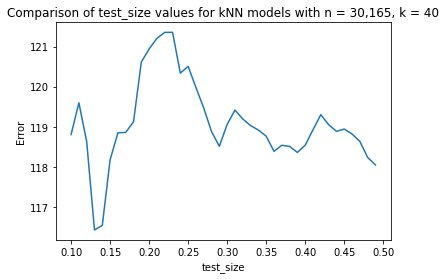

In [18]:
plt.plot(testsize_vals,rmse_vals)
plt.xlabel('test_size')
plt.ylabel('Error')
plt.title("Comparison of test_size values for kNN models with n = 30,165, k = 40")
plt.show()

We can see that test_size = 0.13 minimizes the error, but the error is still 116, which is not great. 

In [19]:
# Create a dataframe that contains all columns, but only rows where landbaseyear is 2021
df_assess = df.copy()
df_assess = df_assess[df_assess['roll_landbaseyear'] == 2021]
df_assess

,sqftmain,roll_landvalue,roll_landbaseyear,center_lat,center_lon,landvaluepersqft
410,1300.0,180000.0,2021,33.976127,-118.256092,138.461538
1972,2211.0,300000.0,2021,33.854559,-118.190454,135.685210
4496,10010.0,2000000.0,2021,34.039579,-118.315336,199.800200
7132,1800.0,460000.0,2021,33.835648,-118.328291,255.555556
9987,6396.0,2000000.0,2021,33.771413,-118.150569,312.695435
10749,1855.0,80000.0,2021,34.678218,-118.451900,43.126685
11612,152076.0,12715000.0,2021,34.223669,-118.377940,83.609511
11898,95976.0,8850000.0,2021,34.109284,-117.824483,92.210553
12887,2080.0,1000000.0,2021,33.918572,-118.401891,480.769231
15333,1561.0,1000000.0,2021,34.083735,-118.599532,640.614990


In [22]:
# Make predictions for the land value per squarefoot for the properties that were assessed in 2021 (y_assess_pred), 
# and compare them to the actual values (y_assess) for various k values
X_assess = pd.DataFrame(df_assess[['roll_landbaseyear','center_lat', 'center_lon']])
y_assess = pd.DataFrame(df_assess['landvaluepersqft'])

rmse_vals2 = []
testsize_vals2 = []

for testsize in np.arange(0.1, 0.5, 0.01):
    # Split data into testing and training
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= testsize, random_state=42)
    # Create model
    model = KNeighborsRegressor(n_neighbors= 40)
    model.fit(X_train,y_train)
    # Make predictions
    y_assess_pred = model.predict(X_assess)
    # Find error
    error = sqrt(mean_squared_error(y_assess, y_assess_pred))
    rmse_vals2 += [error]
    testsize_vals2 += [testsize]
    print('RMSE value for test_size = ', testsize, 'is:', error)

RMSE value for test_size =  0.1 is: 151.9299725400204
RMSE value for test_size =  0.11 is: 151.9299725400204
RMSE value for test_size =  0.12 is: 153.04602848177086
RMSE value for test_size =  0.13 is: 152.61113525476216
RMSE value for test_size =  0.13999999999999999 is: 152.3869386817856
RMSE value for test_size =  0.14999999999999997 is: 153.74473554100717
RMSE value for test_size =  0.15999999999999998 is: 153.52210334677596
RMSE value for test_size =  0.16999999999999998 is: 153.52210334677596
RMSE value for test_size =  0.17999999999999997 is: 153.61428200805148
RMSE value for test_size =  0.18999999999999995 is: 153.61428200805148
RMSE value for test_size =  0.19999999999999996 is: 153.61428200805148
RMSE value for test_size =  0.20999999999999996 is: 153.40174191714584
RMSE value for test_size =  0.21999999999999995 is: 153.6824069257541
RMSE value for test_size =  0.22999999999999995 is: 153.3303774181633
RMSE value for test_size =  0.23999999999999994 is: 153.75883884299634
R

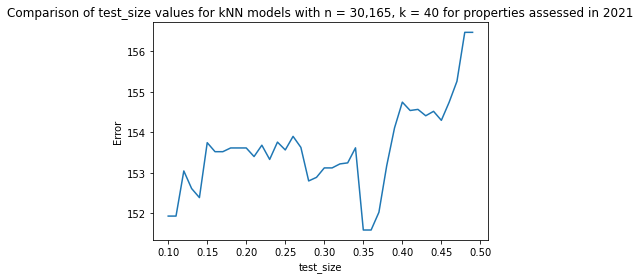

In [23]:
plt.plot(testsize_vals2, rmse_vals2)
plt.xlabel('test_size')
plt.ylabel('Error')
plt.title("Comparison of test_size values for kNN models with n = 30,165, k = 40 for properties assessed in 2021")
plt.show()

We can see that test_size = 0.35 minimizes the error, but the error is still 151.6, which is still bad. 